In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import stats


import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, auc



In [2]:
META_DATA_PATH="../Data/instagram_data.csv"
x_columns = ["no_of_comments", "t", "follower_count_at_t"]
y_columns = ["likes_level"]
TEST_RATIO = 0.2
RANDOM_STATE = 0

In [3]:
def remove_outliers(df): 
    data_no_outliers = df.copy()
    factor = 5
    for c in df.select_dtypes(include=['number']).columns:
        Q1 = data_no_outliers[c].quantile(0.25)
        Q3 = data_no_outliers[c].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        data_no_outliers = data_no_outliers[(data_no_outliers[c] >= lower_bound) & (data_no_outliers[c] <= upper_bound)]
    return data_no_outliers

def plot_roc(data_y, data_y_predict, predict_y_prob, model, title):
    fig, axes = plt.subplots(figsize = (12, 9))
    axes.set_title(f"{title} ROC curve")
    for i, class_ in enumerate(model.classes_):
        fpr, tpr, thresholds = roc_curve(data_y, data_y_predict, pos_label = class_)
        roc_auc = auc(fpr, tpr)
        actions_dict = {0: "Low", 1: "Medium", 2: "High"}
        curclass = actions_dict[class_]
        axes.plot(fpr, tpr, label=f"Class: {curclass}; ROC Curve Area: {round(roc_auc, 3)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("FPR")
    axes.set_ylabel("TPR")
    axes.legend()
    plt.show()
    
def calculate_confusion_matrix(y_data, y_data_pred, title):
    cm = confusion_matrix(y_data.to_numpy(dtype=float), y_data_pred)
    print(f"{title} Confusion Matrix")
    print ("{:>5} {:>5} {:>5} {:>5}".format(' ','0','1','2'))
    for i in range(0, len(cm)):
        print ("{:>5} {:>5} {:>5} {:>5}".format(i, cm[i][0], cm[i][1], cm[i][2]))
    
    

    



In [4]:
meta_df=pd.read_csv(META_DATA_PATH)

data_no_outliers = remove_outliers(meta_df).reset_index(drop = True)


likes_level = []

sorted_likes = data_no_outliers["likes"].sort_values().reset_index(drop = True)
level_0_bound = sorted_likes[int(len(sorted_likes) * 0.33)]
level_1_bound = sorted_likes[int(len(sorted_likes) * 0.67)]

for i in range(0, len(data_no_outliers)):
    if data_no_outliers["likes"][i] <= level_0_bound:
        likes_level.append(0)
    elif data_no_outliers["likes"][i] <= level_1_bound:
        likes_level.append(1)
    else:
        likes_level.append(2)

data_no_outliers["likes_level"] = likes_level
data_no_outliers

,likes,no_of_comments,t,follower_count_at_t,image_path,likes_level
0,154552,0,1594174009,40934474,../Data/insta_data/0.jpg,1
1,97386,0,1593571666,40934474,../Data/insta_data/2.jpg,1
2,145632,0,1593136341,40934474,../Data/insta_data/4.jpg,1
3,76461,0,1592981047,40934474,../Data/insta_data/6.jpg,1
4,174620,0,1592703461,40934474,../Data/insta_data/8.jpg,1
...,...,...,...,...,...,...
3570,341895,6029,1555164674,4229627,../Data/insta_data/9435.jpg,2
3571,217095,2591,1554706282,4229627,../Data/insta_data/9436.jpg,2
3572,17902,253,1553945996,4229627,../Data/insta_data/9437.jpg,0
3573,141694,1175,1552645088,4229627,../Data/insta_data/9442.jpg,1


In [5]:
x_train, x_test, y_train, y_test = train_test_split(data_no_outliers[x_columns], 
                                                    data_no_outliers[y_columns], 
                                                    test_size = TEST_RATIO, 
                                                    random_state = RANDOM_STATE)

In [6]:
y_test

,likes_level
3035,2
1695,2
457,1
1887,1
1414,2
...,...
2087,2
874,1
1953,2
1424,1


Accuracy: 0.77
 
--------------------------------------------------
 
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       241
           1       0.68      0.71      0.70       252
           2       0.81      0.81      0.81       222

    accuracy                           0.77       715
   macro avg       0.77      0.77      0.77       715
weighted avg       0.77      0.77      0.77       715

 
--------------------------------------------------
 
Random Forest Confusion Matrix
          0     1     2
    0   192    43     6
    1    37   179    36
    2     3    40   179
 
--------------------------------------------------
 


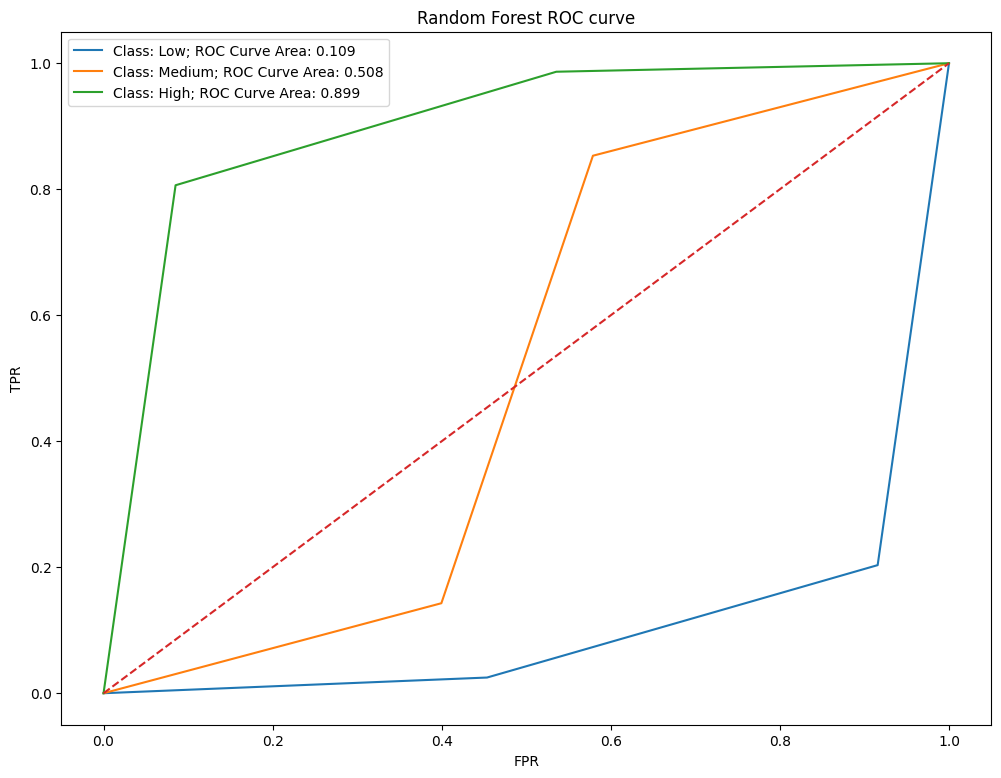

In [7]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(x_train, y_train.values.ravel())

def print_separation():
    print(" ")
    print("--------------------------------------------------")
    print(" ")
    
def create_report(model, title):
    y_pred = model.predict(x_test)
    y_pred_prob = model.predict_proba(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print_separation()
    print(report)
    print_separation()
    calculate_confusion_matrix(y_test, y_pred, title)
    print_separation()
    plot_roc(y_test, y_pred, y_pred_prob, model, title)


create_report(random_forest_model, "Random Forest")
    



Accuracy: 0.55
 
--------------------------------------------------
 
              precision    recall  f1-score   support

           0       0.54      0.70      0.61       241
           1       0.51      0.41      0.45       252
           2       0.62      0.55      0.58       222

    accuracy                           0.55       715
   macro avg       0.55      0.55      0.55       715
weighted avg       0.55      0.55      0.54       715

 
--------------------------------------------------
 
KNN Confusion Matrix
          0     1     2
    0   168    52    21
    1    94   103    55
    2    52    48   122
 
--------------------------------------------------
 


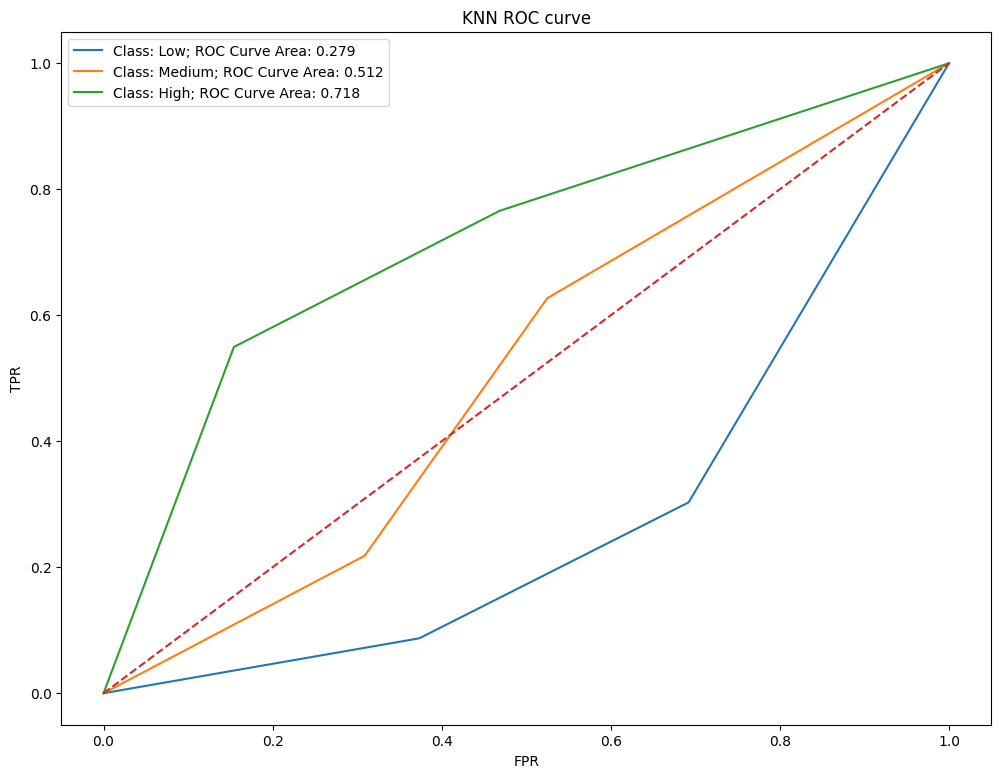

In [8]:

knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(x_train, y_train.values.ravel())

create_report(knn_model, "KNN")

Accuracy: 0.30
 
--------------------------------------------------
 
              precision    recall  f1-score   support

           0       0.33      0.54      0.41       241
           1       0.11      0.03      0.05       252
           2       0.32      0.35      0.33       222

    accuracy                           0.30       715
   macro avg       0.25      0.31      0.26       715
weighted avg       0.25      0.30      0.26       715

 
--------------------------------------------------
 
Multinominal NB Confusion Matrix
          0     1     2
    0   131    33    77
    1   153     8    91
    2   114    30    78
 
--------------------------------------------------
 


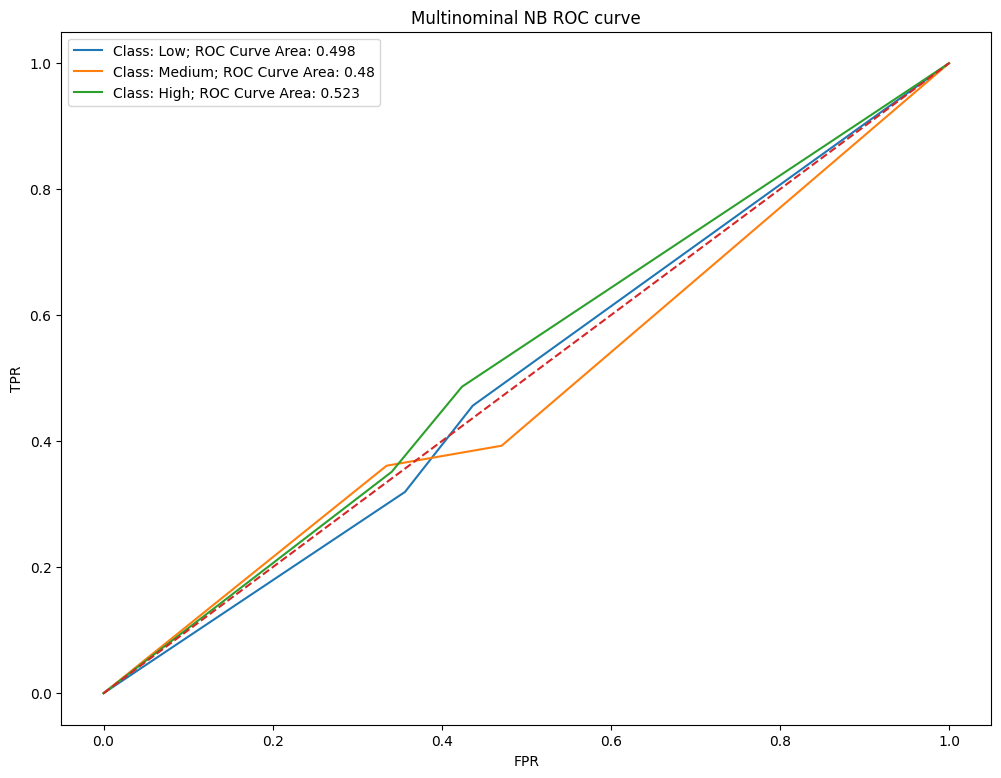

In [9]:
multi_nb_classifier = MultinomialNB()
multi_nb_classifier.fit(x_train, y_train.values.ravel())

create_report(multi_nb_classifier, "Multinominal NB")

# y_pred_nb = nb_classifier.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred_nb)
# print(f"Accuracy: {accuracy:.2f}")
# report = classification_report(y_test, y_pred_knn)
# print(report)

Accuracy: 0.59
 
--------------------------------------------------
 
              precision    recall  f1-score   support

           0       0.57      0.85      0.69       241
           1       0.50      0.41      0.45       252
           2       0.78      0.51      0.62       222

    accuracy                           0.59       715
   macro avg       0.62      0.59      0.59       715
weighted avg       0.61      0.59      0.58       715

 
--------------------------------------------------
 
Guassian NB Confusion Matrix
          0     1     2
    0   206    29     6
    1   121   104    27
    2    33    75   114
 
--------------------------------------------------
 


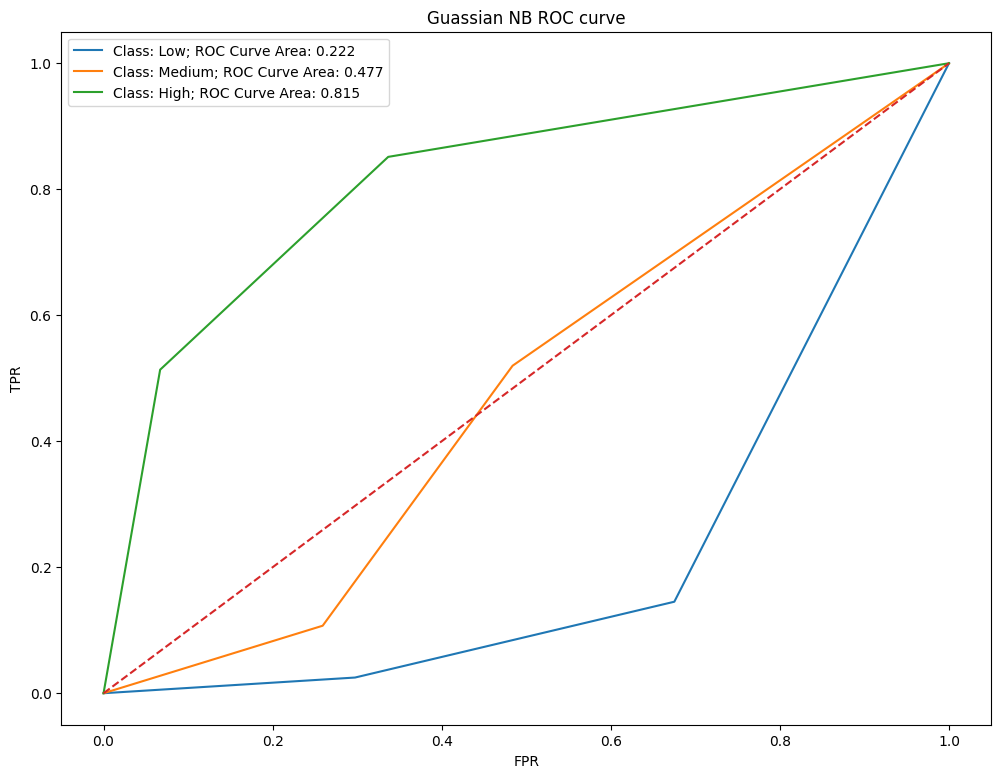

In [10]:
g_classifier = GaussianNB()
g_classifier.fit(x_train, y_train.values.ravel())

create_report(g_classifier, "Guassian NB")


In [11]:
# cur_column = ["no_of_comments", "follower_count_at_t"]
column_composition = [
    ["no_of_comments", "follower_count_at_t", "t"], 
    ["no_of_comments", "follower_count_at_t"], 
    ["t", "follower_count_at_t"],
    ["no_of_comments", "t"]
]

def create_report_for_composition(model, title, cur):
    y_pred = model.predict(x_test[cur])
    y_pred_prob = model.predict_proba(x_test[cur])
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print_separation()
    print(report)
    print_separation()
    calculate_confusion_matrix(y_test, y_pred, title)

for cur in column_composition:
    rft_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rft_model.fit(x_train[cur], y_train.values.ravel())
    print(f"Current Report Random Forest - {cur}")
    create_report_for_composition(rft_model, f"Random Forest - {cur}", cur)
    print_separation()
    print_separation()
    # print(x_train[cur_column])


Current Report Random Forest - ['no_of_comments', 'follower_count_at_t', 't']
Accuracy: 0.77
 
--------------------------------------------------
 
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       241
           1       0.69      0.71      0.70       252
           2       0.81      0.81      0.81       222

    accuracy                           0.77       715
   macro avg       0.78      0.78      0.78       715
weighted avg       0.78      0.77      0.77       715

 
--------------------------------------------------
 
Random Forest - ['no_of_comments', 'follower_count_at_t', 't'] Confusion Matrix
          0     1     2
    0   194    41     6
    1    37   180    35
    2     2    41   179
 
--------------------------------------------------
 
 
--------------------------------------------------
 
Current Report Random Forest - ['no_of_comments', 'follower_count_at_t']
Accuracy: 0.76
 
----------------------------------------